In [1]:
import math, glob, itertools, numpy as np, pandas as pd, pint_pandas, matplotlib as mpl, matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

dtime_t = pd.to_timedelta(1, unit='s')

data_glob_path  = 'data/dmm.*.csv'
plot_start_time = pd.to_timedelta(1, unit='s')
power_map = {
     0 : '0 W',
     1 : '0.5 W',
     2 : '0.5 W',
     3 : '0.5 W',
     4 : '1 W',
     5 : '1 W',
     6 : '1 W',
     7 : '1.5 W',
     8 : '1.5 W',
     9 : '1.5 W',
    10 : '0 W',
}

df = pd.concat([pd.read_csv(f, header=[0], skiprows=[1], index_col=[0]).assign(Sample=int(f.split('.')[1])) for f in glob.iglob(data_glob_path)], ignore_index=True)

df.index          = pd.to_timedelta(df.Time, unit='s')
df['Power']       = df.Sample.apply(lambda n : power_map[n % 11])
df['Copy']        = df.Sample.apply(lambda n : '#2' if (n // 11) % 2 else '#1')
df['Face']        = df.Sample.apply(lambda n : 'Back' if n // 44 else 'Front')
df['Orientation'] = df.Sample.apply(lambda n : 'Perpendicular' if (n // 22) % 2 else 'Parallel')
max_sample_time = max([data.Time.diff().max() for _, data in df.groupby('Sample')]) * dtime_t

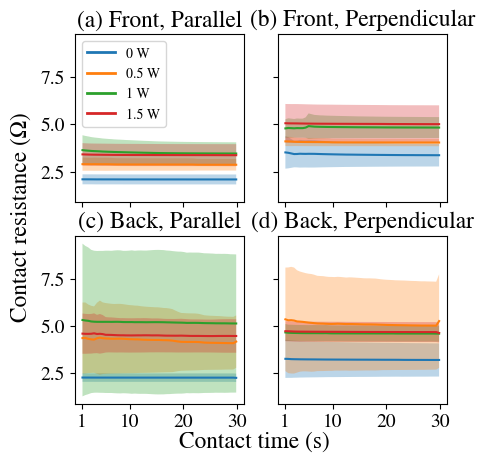

In [2]:
mpl.rcParams['font.size']        = 14
mpl.rcParams['font.family']      = 'STIXGeneral'
mpl.rcParams['mathtext.fontset'] = 'stix'
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=mpl.figure.figaspect(1))
lines = []

for (title, gf), ax, i in zip(df.groupby(['Face', 'Orientation']), np.flip(axes, 0).reshape(-1), [2, 3, 0, 1]):
    ax.set_title(f'({chr(ord("a") + i)}) {", ".join(title)}')
    for (label, gff), j in zip(gf.groupby('Power'), itertools.count()):
        res    = pd.concat([data.Resistance.resample(max_sample_time).mean() for sample, data in gff.groupby('Sample')], axis=1)
        r_mean = res.mean(axis=1)[res.index >= plot_start_time]
        r_std  = res.std(axis=1)[res.index >= plot_start_time]

        plot = ax.plot(r_mean.index / dtime_t, r_mean, color=palette[j], label=label)
        ax.fill_between(r_mean.index / dtime_t, r_mean + r_std, r_mean - r_std, facecolor=palette[j], alpha=0.3)
        if i == 0:
            lines += plot

plt.xticks([1, 10, 20, 30])
fig.supxlabel('Contact time (s)')
fig.supylabel('Contact resistance (Ω)', x=-0.01)

# Style legend
leg = axes[0,0].legend(
    lines,
    [l.get_label() for l in lines],
    loc='upper left',
    fontsize=10,
)
for line in leg.get_lines():
    line.set_linewidth(2)

plt.savefig('plot.png', dpi=600, bbox_inches='tight')
plt.show()